### Betfair data testing

In [49]:
import betfairlightweight
from betfairlightweight import filters
import pandas as pd
import numpy as np
import os
import datetime
import json
#import git
from bz2 import BZ2File
import matplotlib.pyplot as plt

logins_dir =  'C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\api_logins.json' #str(repo.working_tree_dir) + "/api_logins.json"

with open(logins_dir) as f:
    login_dict =  json.load(f)
    
trading = betfairlightweight.APIClient(username=login_dict['my_username'],
                                       password=login_dict['my_password'],
                                       app_key=login_dict['my_app_key'],
                                       certs=login_dict['certs_path'])

trading.login()

<LoginResource>

In [4]:
# Lists the data that you have purchased on your Betfair account
my_data = trading.historic.get_my_data()
for i in my_data:
    print(i)

{'sport': 'Horse Racing', 'plan': 'Pro Plan', 'forDate': '2020-04-01T00:00:00', 'purchaseItemId': 41353}
{'sport': 'Horse Racing', 'plan': 'Pro Plan', 'forDate': '2020-05-01T00:00:00', 'purchaseItemId': 41353}


In [5]:
# Breaks down the contents of the data you want to look into
collection_options = trading.historic.get_collection_options(
    "Horse Racing", "Pro Plan", 1, 4, 2020, 1, 4, 2020
)

print(collection_options)

{'marketTypesCollection': [{'name': '', 'count': 19}, {'name': 'MATCH_BET', 'count': 54}, {'name': 'OTHER_PLACE', 'count': 18}, {'name': 'PLACE', 'count': 96}, {'name': 'RACE_WIN_DIST', 'count': 3}, {'name': 'WIN', 'count': 142}], 'countriesCollection': [{'name': 'AU', 'count': 231}, {'name': 'HK', 'count': 2}, {'name': 'JP', 'count': 25}, {'name': 'SE', 'count': 32}, {'name': 'US', 'count': 42}], 'fileTypeCollection': [{'name': 'E', 'count': 19}, {'name': 'M', 'count': 313}]}


In [6]:
basket_size = trading.historic.get_data_size(
    "Horse Racing", "Pro Plan", 1, 4, 2020, 1, 4, 2020
)
print(basket_size)

{'totalSizeMB': 120, 'fileCount': 332}


In [7]:
# Test sample, April 1st US horse racing data
file_list = trading.historic.get_file_list(
    "Horse Racing",
    "Pro Plan",
    from_day=1,
    from_month=4,
    from_year=2020,
    to_day=1,
    to_month=4,
    to_year=2020,
    market_types_collection=["WIN", "PLACE"],
    countries_collection=["US"],
    file_type_collection=["M"],
)
print(file_list)

['/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262288.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262291.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262294.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262297.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762726/1.170262314.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262300.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762726/1.170262317.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262303.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762726/1.170262320.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262306.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762726/1.170262323.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262309.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762726/1.170262326.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762726/1.170262329.bz2', '/xds_nfs/edp_processed/PRO/2020/Apr/1/29762726/1.170262332.bz2', '/xds_nfs

In [8]:
# Downloading the first file in that list. Each file is one race.
file = file_list[1]
print(file)
download = trading.historic.download_file(file_path=file)
print(download)

/xds_nfs/edp_processed/PRO/2020/Apr/1/29762723/1.170262291.bz2
1.170262291.bz2


In [10]:
# Extracting the bz2 file to the working directory
filename = str(download)
zipfile = BZ2File(filename) # open the file
data = zipfile.read() # get the decompressed data
newfilepath = filename[:-4] # assuming the filepath ends with .bz2
open(newfilepath, 'wb').write(data) # write a uncompressed file
zipfile.close()

## Using stream listener to read extracted data

In [11]:
from betfairlightweight import StreamListener
from betfairlightweight.streaming.stream import MarketStream

class HistoricalStream(MarketStream):
    # create custom listener and stream

    def __init__(self, listener):
        super(HistoricalStream, self).__init__(listener)
        with open("output.txt", "w") as output:
            output.write("Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded\n")

    def on_process(self, market_books):
        with open("output.txt", "a") as output:
            for market_book in market_books:
                for runner in market_book.runners:

                    # how to get runner details from the market definition
                    market_def = market_book.market_definition
                    runners_dict = {
                        (runner.selection_id, runner.handicap): runner
                        for runner in market_def.runners
                    }
                    runner_def = runners_dict.get(
                        (runner.selection_id, runner.handicap)
                    )

                    output.write(
                        "%s,%s,%s,%s,%s,%s\n"
                        % (
                            market_book.publish_time,
                            market_book.market_id,
                            market_book.status,
                            market_book.inplay,
                            runner.selection_id,
                            runner.last_price_traded or "",
                        )
                    )


class HistoricalListener(StreamListener):
    def _add_stream(self, unique_id, stream_type):
        if stream_type == "marketSubscription":
            return HistoricalStream(self)
        
listener = HistoricalListener(max_latency=None)

stream = trading.streaming.create_historical_stream(
    directory=newfilepath,
    listener=listener,
)

In [12]:
stream.start()
#fills output.txt

In [37]:
df = pd.read_csv('output.txt')
df.head()

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded
0,2020-03-31 21:48:14.305000,1.170262,OPEN,False,28268326,NaN
1,2020-03-31 21:48:14.305000,1.170262,OPEN,False,23801577,NaN
2,2020-03-31 21:48:14.305000,1.170262,OPEN,False,20121107,NaN
3,2020-03-31 21:48:14.305000,1.170262,OPEN,False,20953841,NaN
4,2020-03-31 21:48:14.305000,1.170262,OPEN,False,232439,NaN


In [36]:
print(df.iloc[-1]) #shows 287168 rows

Time               2020-04-01 17:07:04.054000
MarketId                              1.17026
Status                                 CLOSED
Inplay                                   True
SelectionId                          23297643
LastPriceTraded                             2
Name: 287167, dtype: object


In [16]:
#Picking one horse and following seeing its price movements

# Finding selection ids
column_values = df['SelectionId'].values.ravel()
unique_values =  pd.unique(column_values)
print(unique_values)

[28268326 23801577 20121107 20953841   232439 24832946 19034043 11422636
 15757903 12263578 25024669  5477434 27891505 23297643]


In [68]:
df_inplay = df[df.Time > "2020-04-01 17:03:30"]
df_inplay.head()

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded
272818,2020-04-01 17:03:30.087000,1.170262,OPEN,False,28268326,50.89
272819,2020-04-01 17:03:30.087000,1.170262,OPEN,False,23801577,38.00
272820,2020-04-01 17:03:30.087000,1.170262,OPEN,False,20121107,3.45
272821,2020-04-01 17:03:30.087000,1.170262,OPEN,False,20953841,8.20
272822,2020-04-01 17:03:30.087000,1.170262,OPEN,False,232439,5.26


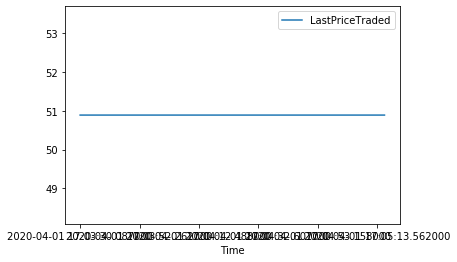

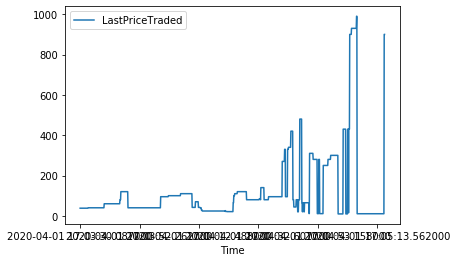

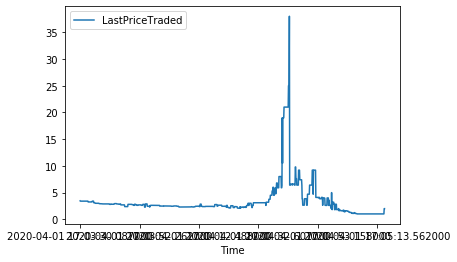

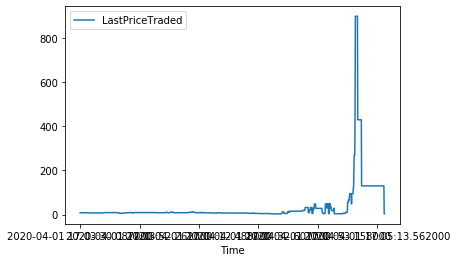

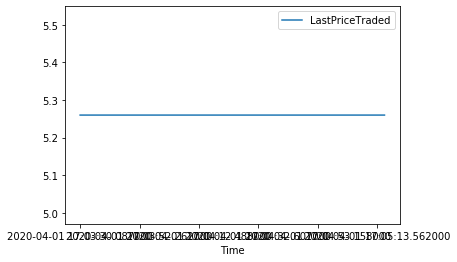

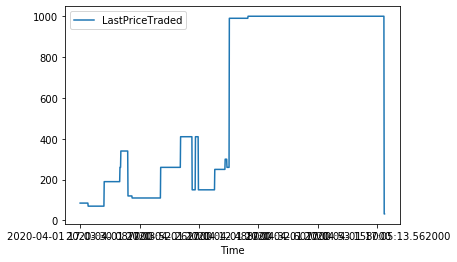

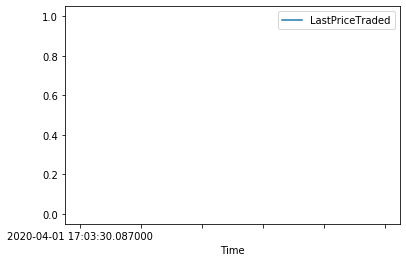

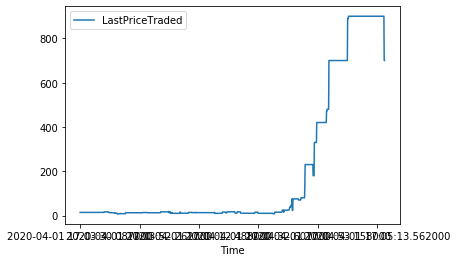

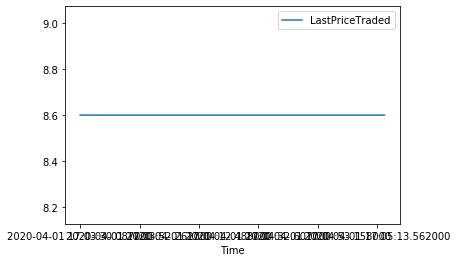

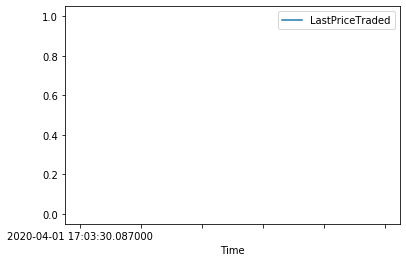

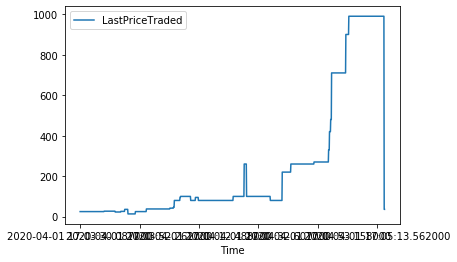

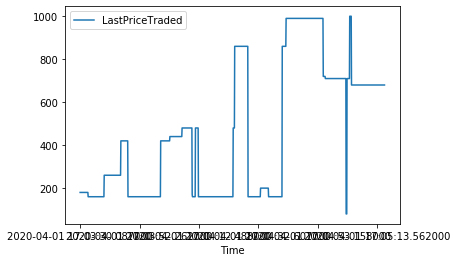

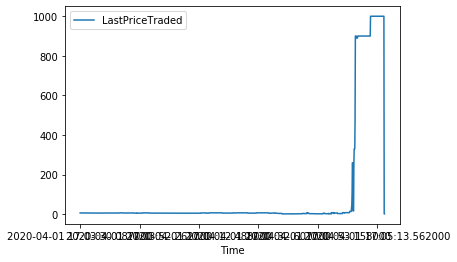

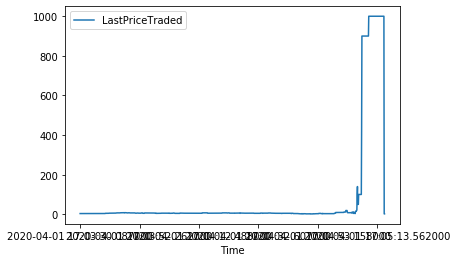

In [69]:
for i in unique_values:
    df_inplay[df_inplay['SelectionId'] == i].plot(x='Time', y='LastPriceTraded')
    